In [1]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "../data/chest_xray/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_data = val_gen.flow_from_directory(
    "../data/chest_xray/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 [==============================] - 6s 0us/step


In [4]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 [==============================] - 6s 0us/step


In [4]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 [==============================] - 6s 0us/step


In [5]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
163/163 [==============================] - 167s 1s/step - loss: 0.5646 - accuracy: 0.7304 - auc: 0.6305 - val_loss: 0.7266 - val_accuracy: 0.5000 - val_auc: 0.8359
Epoch 2/10
163/163 [==============================] - 166s 1s/step - loss: 0.4838 - accuracy: 0.7619 - auc: 0.7864 - val_loss: 0.7181 - val_accuracy: 0.5625 - val_auc: 0.8281
Epoch 3/10
163/163 [==============================] - 159s 974ms/step - loss: 0.4427 - accuracy: 0.7786 - auc: 0.8285 - val_loss: 0.6885 - val_accuracy: 0.6250 - val_auc: 0.8281
Epoch 4/10
163/163 [==============================] - 164s 1s/step - loss: 0.4134 - accuracy: 0.8004 - auc: 0.8529 - val_loss: 0.7903 - val_accuracy: 0.5625 - val_auc: 0.8125
Epoch 5/10
163/163 [==============================] - 172s 1s/step - loss: 0.3985 - accuracy: 0.8010 - auc: 0.8655 - val_loss: 0.9941 - val_accuracy: 0.5625 - val_auc: 0.8125
Epoch 6/10
163/163 [==============================] - 160s 978ms/step - loss: 0.4001 - accuracy: 0.8060 - auc: 0.8649 - va

In [7]:
model.save("../model/pneumonia_model.h5")

C:\Users\ASUS\OneDrive\Desktop\MedLens\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
import cv2
import os

Text(0.5, 1.0, 'Original Chest X-ray')

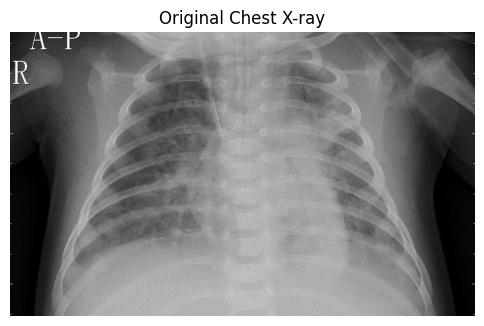

In [9]:
import cv2
import matplotlib.pyplot as plt

img_file = r"C:\Users\ASUS\OneDrive\Desktop\MedLens\data\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg"

img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Original Chest X-ray")

In [10]:
img_resized = cv2.resize(img, (224, 224))
img_array = img_resized / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [11]:
def grad_cam(model, img_array, layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

(-0.5, 6.5, 6.5, -0.5)

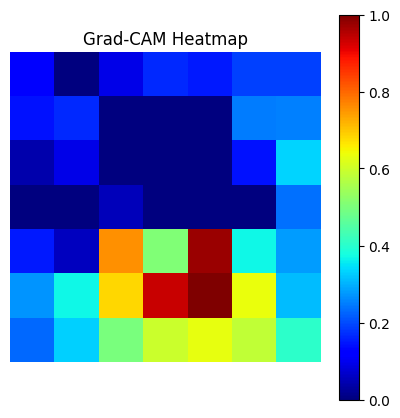

In [12]:
heatmap = grad_cam(model, img_array)

plt.figure(figsize=(5,5))
plt.imshow(heatmap, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM Heatmap")
plt.axis("off")

Text(0.5, 1.0, 'Grad-CAM Overlay on X-ray')

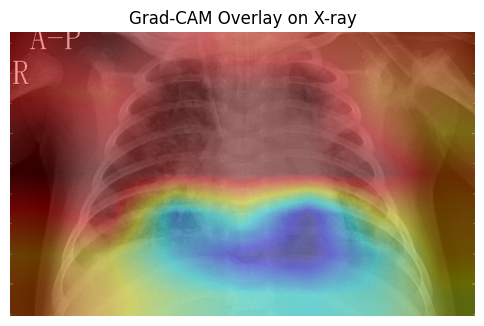

In [13]:
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM Overlay on X-ray")

In [14]:
## Multi-Class Radiology Model (Normal, Pneumonia, COVID-19, TB)

In [15]:
train_dir = "data/chest_xray/train"
val_dir = "data/chest_xray/val"

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical"
)

train_generator.class_indices

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/chest_xray/train'

In [17]:
train_dir = "../data/chest_xray/train"
val_dir = "../data/chest_xray/val"

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical"
)

train_generator.class_indices


Found 8970 images belonging to 4 classes.
Found 3770 images belonging to 4 classes.


{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TUBERCULOSIS': 3}

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [20]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [21]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
561/561 [==============================] - 475s 843ms/step - loss: 0.9117 - accuracy: 0.5648 - val_loss: 0.4365 - val_accuracy: 0.9204
Epoch 2/10
561/561 [==============================] - 442s 788ms/step - loss: 0.6766 - accuracy: 0.7074 - val_loss: 0.4599 - val_accuracy: 0.8743
Epoch 3/10
561/561 [==============================] - 456s 813ms/step - loss: 0.5538 - accuracy: 0.7734 - val_loss: 0.2440 - val_accuracy: 0.9446
Epoch 4/10
561/561 [==============================] - 471s 840ms/step - loss: 0.4968 - accuracy: 0.7980 - val_loss: 1.2776 - val_accuracy: 0.2989
Epoch 5/10
561/561 [==============================] - 525s 936ms/step - loss: 0.4640 - accuracy: 0.8123 - val_loss: 0.3529 - val_accuracy: 0.9011
Epoch 6/10
561/561 [==============================] - 495s 883ms/step - loss: 0.4090 - accuracy: 0.8372 - val_loss: 0.2679 - val_accuracy: 0.9215
Epoch 7/10
561/561 [==============================] - 529s 944ms/step - loss: 0.4062 - accuracy: 0.8421 - val_loss: 0.1601 -

In [22]:
model.save("model/multiclass_radiology_model.h5")

In [23]:
model.save("model/multiclass_radiology_model.h5")